# Neural Networks with Keras

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Python >= 3.5 is required 
import sys
assert sys.version_info >= (3, 5)

#Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Tensorflow >=2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd
import numpy as np
import os 

# Stabilizing outputs across multiple notebook runs
np.random.seed(42)

# Plotting libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

# Un-comment if the figures of this notebook need to be saved

# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "ann"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=480):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore inconsequential warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


## Perceptrons

Implementing a single layer / single-TLU (threshold logic unit) Perceptron.

In [9]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width inside the parenthesis
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [10]:
y_pred

array([1])

In [11]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.coef_[0][0] / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1)
        )

X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

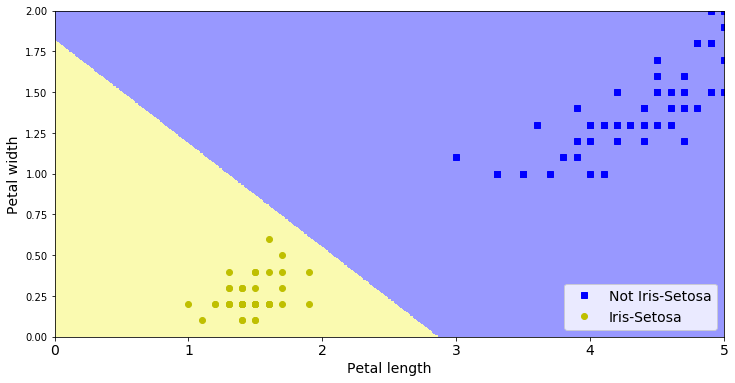

In [16]:
# Plotting the results of the above
from matplotlib.colors import ListedColormap

plt.figure(figsize=(12, 6))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show();

## Activation Functions

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps = 0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

Let's visualize these activation functions for better clarity...

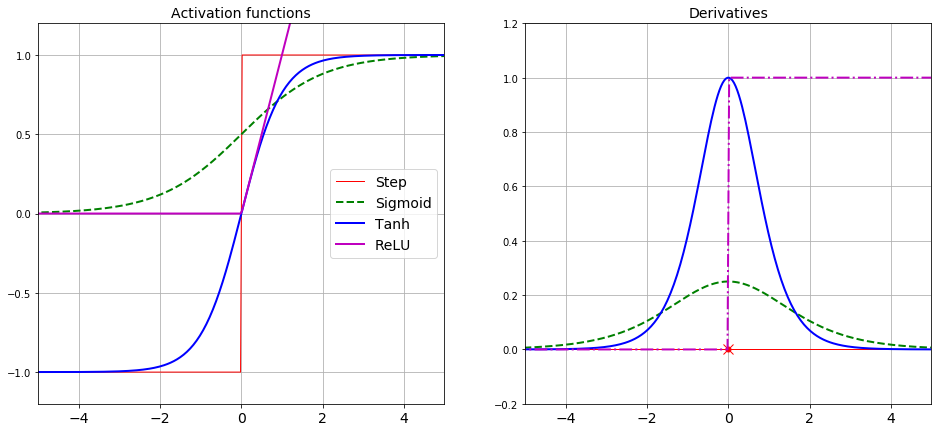

In [27]:
z = np.linspace(-10, 10, 500)

plt.figure(figsize = (16, 7))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show();

## Building an Image Classifier Using Tensorflow and Keras

In [28]:
import tensorflow as tf
from tensorflow import keras

Let's start by loading the fashion MNIST dataset. We'll be using Keras to load popular datasets in **keras.datasets**. As a reminder, the dataset has already been split between a training and a test set.

In [29]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 8s 2us/step


In [30]:
X_train_full.shape

(60000, 28, 28)

In [31]:
X_train_full.dtype

dtype('uint8')

Since we are going to train the NN using SGD, we must scale the input features. For simplicity, we'll scale the pixel intensities down to 0 - 1 and convert them to floats.

In [38]:
# Splitting into training and validation sets
# We shall scale the pixel intensities down to the 0-1 range and convert to floats
# by dividing by 255.
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255. 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

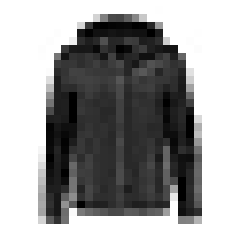

In [56]:
# Plotting using imshow() with a binary color map
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show();

In [51]:
# Checking labels
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [52]:
# Adding the corresponding class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [53]:
# Verifying labels
class_names[y_train[0]], class_names[y_train[1]]

('Coat', 'T-shirt/top')